# GANs for the MNIST dataset

In this notebook we will implement a generative adversarial network (GAN) for generating digits resembling those from the MNIST data set.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## GANs on a nutshell

GANs are relevant tools for generating data from complex probability distributions (especially, probability distributions over images). They view the sampling process as a game between two agents: a **generator** (*G*) and a **discriminator** (*D*).

*G* generates samples of data intended to come from the same distribution as the real data $p_{data}$. *D* is trained to distinguish real data from fake data (generated by *G*). This is a simple classication task. In turn, *G* is trained to fool *D* in its task. Each player is seen as a diffentiable function with some parameters $\theta^{(G)}$ (for the generator) and $\theta^{(D)}$ (for the discriminator). The discriminator is simply a function that maps a given image into a scalar value, representing the probability of the image being real. The generator, maps a prior noise (usually belonging to a low dimension latent space) into an image of the same size as the real images.

 <img src="img/gan.jpeg">
         
#### Cost functions

One popular choice for the discriminator's cost function is the Binary Cross Entropy. In that case, assuming that the data is balanced (same number of fake and real images), the cost function is

$$
C(\theta^{(D)}, \theta^{(G)}) = -\frac{1}{2} \mathbb{E}_{x \sim p_{data}}[\log(D(x))] - \frac{1}{2} \mathbb{E}_{z}[\log(1- D(G(z)))] 
$$

The discriminator will choose $\theta^{(D)}$ minimizing these function.

Under the minimax setting, the loss for the generator is just $-C(\theta^{(D)}, \theta^{(G)})$. Thus, the optimal value (equilibrium) of the generator's parameters is

$$
\theta^{*(G)} = \arg\min_{\theta^{(G)}} \left \lbrace \max_{\theta^{(D)}} [-C(\theta^{(D)}, \theta^{(G)})] \right \rbrace
$$

As this objetive is intractable to optimize exactly (as requieres solving a bilevel optimization problem), the usual approach is to perform silmultaneous stochastic gradient descent: at each iteration, we first uptade the parameters of one of the players, and then the other's. 

Now we will try to implement this approach to generate digits from MNIST.

## GANs on MNIST

### Plotting function

In [22]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def plot_result(generator, noise, num_epoch=1, save=False, save_dir='MNIST_GAN_results/', show=True, fig_size=(5, 5)):
    generator.eval()

    noise = noise.to(device)
    gen_image = generator(noise)
    gen_image = denorm(gen_image)


    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        ax.imshow(img.cpu().data.view(image_size, image_size).numpy(), cmap='gray', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')
    
    plt.show()

In [23]:
image_size = 28
batch_size = 128
Gn_hidden = [256, 512, 1024]   # Sizes of the hidden layers
Dn_hidden = Gn_hidden
dim_z = 100
lr = 0.0001
n_out = 28*28
num_epochs = 100
device="cuda"

### Get the data

We are going to load the dataset. Since the MNIST dataset is very popular, PyTorch already has it included into datasets.MNIST, and will automatically download it the first time. We can also specify some transformations, like converting the matrix to a tensor and normalize the pixels

Note that we create two data loaders: one for the training set and another one for the testing set. Since this is just a quick experiment, we are not going to validate the initial hyperparameters, so we don't create another data loader for a validation set.

The main benefit of the DataLoader class is that it creates an object which can be used in a for loop, as we did in the previous train function, to iterate over the minibatches.

In [24]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=True)


Let's visualize some examples together with the true labels.

In [5]:
examples = enumerate(train_loader)
batch_idx, (example, label) = next(examples)
example.shape

torch.Size([512, 1, 28, 28])

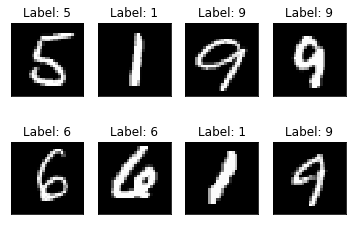

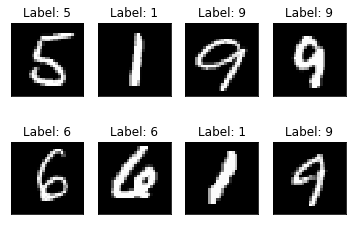

In [6]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(example[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Model Definition

In [60]:
# Generator model
class Generator(torch.nn.Module):
    def __init__(self, hidden_dims, input_dim, output_dim):
        super(Generator, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dims[0])
        self.lin2 = torch.nn.Linear(hidden_dims[0], hidden_dims[1])
        self.lin3 = torch.nn.Linear(hidden_dims[1], hidden_dims[2])
        self.output_layer = torch.nn.Linear(hidden_dims[2], output_dim)
    
    def forward(self, x):
        h = F.leaky_relu(self.lin1(x), negative_slope=0.2)
        h = F.leaky_relu(self.lin2(h), negative_slope=0.2)
        h = F.leaky_relu(self.lin3(h), negative_slope=0.2)
        out = F.tanh(self.output_layer(h))
        return out



# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, hidden_dims, n_out):
        super(Discriminator, self).__init__()
        input_dim = n_out
        self.Dropout = torch.nn.Dropout(0.3)
        self.lin1 = torch.nn.Linear(input_dim, hidden_dims[0])
        self.lin2 = torch.nn.Linear(hidden_dims[0], hidden_dims[1])
        self.lin3 = torch.nn.Linear(hidden_dims[1], hidden_dims[2])
        self.output_layer = torch.nn.Linear(hidden_dims[2], 1)
        
        
    def forward(self,x):
        h = F.leaky_relu(self.lin1(x), negative_slope=0.2)
        h = self.Dropout(h)
        h = F.leaky_relu(self.lin2(h), negative_slope=0.2)
        h = self.Dropout(h)
        h = F.leaky_relu(self.lin3(h), negative_slope=0.2)
        h = self.Dropout(h)
        out = F.sigmoid(self.output_layer(h))
        return out

### GAN Loss Definition

In [61]:
gen = Generator(Gn_hidden, dim_z, n_out).to(device)
disc = Discriminator(Dn_hidden, n_out).to(device)
##
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
disc_optimizer = optim.Adam(disc.parameters(), lr=lr)

#### Minimax

In [62]:
disc_avg_losses = []
gen_avg_losses = []
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, dim_z)
bce = torch.nn.BCELoss()

In [ ]:
disc_avg_losses = []
gen_avg_losses = []
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, dim_z)
bce = torch.nn.BCELoss()
##
for epoch in range(num_epochs):
    
    disc_losses = []
    gen_losses = []

    # minibatch training
    for i, (images, _) in enumerate(train_loader):

        # image data
        batch_size = images.size()[0]
        x_ = images.view(-1, n_out).to(device)

        # labels
        y_real_ = torch.ones(batch_size, 1).to(device)
        y_fake_ = torch.zeros(batch_size, 1).to(device)

        # Train discriminator with real data
        disc_real_decision = disc(x_)
        disc_real_loss = bce(disc_real_decision, y_real_)
        
        # Train discriminator with fake data
        zmodel = torch.randn(batch_size, dim_z).to(device)
        gen_image = gen(zmodel)
        disc_fake_decision = disc(gen_image)
        disc_fake_loss = bce(disc_fake_decision, y_fake_)
        
        disc_loss = disc_real_loss + disc_fake_loss
        ## Take grads
        disc.zero_grad()
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # Train generator
        zmodel = torch.randn(batch_size, dim_z).to(device)
        gen_image = gen(zmodel)
        disc_fake_decision = disc(gen_image)
        disc_fake_loss = bce(disc_fake_decision, y_fake_)

        gen_loss = -( disc_fake_loss + disc_real_loss )

        # Back propagation
        disc.zero_grad()
        gen.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # loss values
        disc_losses.append(disc_loss.data)
        gen_losses.append(gen_loss.data)
        
        if i%1000==0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), disc_loss.data, gen_loss.data))

    disc_avg_loss = torch.mean(torch.FloatTensor(disc_losses))
    gen_avg_loss = torch.mean(torch.FloatTensor(gen_losses))

    # avg loss values for plot
    disc_avg_losses.append(disc_avg_loss)
    gen_avg_losses.append(gen_avg_loss)


    # Show result for fixed noise
    plot_result(gen, fixed_noise, epoch, save=False, fig_size=(5, 5))


As expected, the discriminator is learning fast, causing the generator's loss to be zero, (and its gradientes consequently).

An heuristic solution to this problems, changes the generators loss function to be

$$
- \frac{1}{2} \mathbb{E}_{z} \left[ \log(D(G(z)))\right]
$$

Try this new loss and see if things improve.

#### Heuristic Loss

In [15]:
gen = Generator(Gn_hidden, dim_z, n_out).to(device)
disc = Discriminator(Dn_hidden, n_out).to(device)
##
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
disc_optimizer = optim.Adam(disc.parameters(), lr=lr)

In [16]:
disc_avg_losses = []
gen_avg_losses = []
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, dim_z)
bce = torch.nn.BCELoss()

In [ ]:
for epoch in range(num_epochs):
    
    disc_losses = []
    gen_losses = []

    # minibatch training
    for i, (images, _) in enumerate(train_loader):

        # image data
        batch_size = images.size()[0]
        x_ = images.view(-1, n_out).to(device)

        # labels
        y_real_ = torch.ones(batch_size, 1).to(device)
        y_fake_ = torch.zeros(batch_size, 1).to(device)

        # Train discriminator with real data
        disc_real_decision = disc(x_)
        disc_real_loss = bce(disc_real_decision, y_real_)
        
        # Train discriminator with fake data
        zmodel = torch.randn(batch_size, dim_z).to(device)
        gen_image = gen(zmodel)
        disc_fake_decision = disc(gen_image)
        disc_fake_loss = bce(disc_fake_decision, y_fake_)
        
        disc_loss = disc_real_loss + disc_fake_loss
        ## Take grads
        disc.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Train generator
        zmodel = torch.randn(batch_size, dim_z).to(device)
        gen_image = gen(zmodel)

        disc_fake_decision = disc(gen_image)
        gen_loss = bce(disc_fake_decision, y_real_)

        # Back propagation
        disc.zero_grad()
        gen.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # loss values
        disc_losses.append(disc_loss.data)
        gen_losses.append(gen_loss.data)
        
        if i%1000==0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), disc_loss.data, gen_loss.data))

    disc_avg_loss = torch.mean(torch.FloatTensor(disc_losses))
    gen_avg_loss = torch.mean(torch.FloatTensor(gen_losses))

    # avg loss values for plot
    disc_avg_losses.append(disc_avg_loss)
    gen_avg_losses.append(gen_avg_loss)


    # Show result for fixed noise
    plot_result(gen, fixed_noise, epoch, save=False, fig_size=(5, 5))


In [54]:
torch.save(gen.state_dict(), 'gen.pt')
torch.save(disc.state_dict(), 'disc.pt')

In [55]:
# We load some pretrained weights"
gen.load_state_dict(torch.load('gen.pt'))
disc.load_state_dict(torch.load('disc.pt'))

<All keys matched successfully>

## Interpolating in the latent space

Given two random samples $z_1, z_2 \in \mathbb{R}^d$ with $d=100$ as in the previous code, we can interpolate in this latent space and generate the corresponding images

In [56]:
torch.manual_seed(16)
z1 = torch.randn(dim_z).to(device)
z2 = torch.randn(dim_z).to(device)

In [57]:
alpha = np.linspace(0, 1, 9)
alpha = np.atleast_2d(alpha).T
alpha = torch.tensor(alpha, dtype=torch.float).to(device)

In [58]:
zs = alpha*z1 + (1-alpha)*z2

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


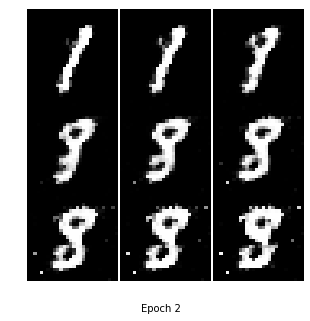

In [59]:
plot_result(gen, zs)